# Regression Challenge

## Preparation / Exploration

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn import preprocessing

/Users/wliao/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Read in data
df = pd.read_csv('cali_crime.csv')

In [4]:
# Preview Data
df.head()

,city of Angels,population,violent_crime,murder_nonnegligent_murder,rape_revised,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motorvehicle_theft,arson,Unnamed: 13
0,Adelanto,"31,165",198,2.0,NaN,15.0,52,129,886,381,372,133,17,NaN
1,Agoura Hills,"20,762",19,0.0,NaN,2.0,10,7,306,109,185,12,7,NaN
2,Alameda,"76,206",158,0.0,NaN,10.0,85,63,"1,902",287,"1,285",330,17,NaN
3,Albany,"19,104",29,0.0,NaN,1.0,24,4,557,94,388,75,7,NaN
4,Alhambra,"84,710",163,1.0,NaN,9.0,81,72,"1,774",344,"1,196",234,7,NaN


In [5]:
# Check for missing values
df.isnull().sum()

city of Angels                  0
population                      2
violent_crime                   2
murder_nonnegligent_murder      2
rape_revised                  464
rape_legacy                     2
robbery                         2
aggravated_assault              2
property_crime                  2
burglary                        2
larceny_theft                   2
motorvehicle_theft              2
arson                           2
Unnamed: 13                   464
dtype: int64

In [6]:
# Drop attributes that appear to not contain any values
df = df.drop('rape_revised',axis=1)
df = df.drop('Unnamed: 13',axis=1)

# Drop city attribute as we'll only be using numeric data for the regression omdel
df = df.drop('city of Angels',axis=1)

# Because there are so few remaining NaN values, we'll rows that have NaN
# values instead of imputing
df = df.dropna()

In [7]:
# Double check to make sure there are no missing values 
df.isnull().sum()

population                    0
violent_crime                 0
murder_nonnegligent_murder    0
rape_legacy                   0
robbery                       0
aggravated_assault            0
property_crime                0
burglary                      0
larceny_theft                 0
motorvehicle_theft            0
arson                         0
dtype: int64

In [8]:
# Preview data types for remaining attributes
df.dtypes

population                     object
violent_crime                  object
murder_nonnegligent_murder    float64
rape_legacy                   float64
robbery                        object
aggravated_assault             object
property_crime                 object
burglary                       object
larceny_theft                  object
motorvehicle_theft             object
arson                          object
dtype: object

In [9]:
# Remove commas from objects
for column in df.columns:
    if df[column].dtype == 'O':
        df[column] = df[column].str.replace(',','')

In [10]:
# Convert all attributes to numeric for model
for column in df.columns:
    df[column] = pd.to_numeric(df[column],errors='coerce')

In [11]:
# Create binary target variable for regression model 
# 0 = robbery did not occur, 1 = robbery did occur
df['robbery_target'] = np.where((df['robbery'] > 0),1,0)

In [12]:
# Drop original 'robbery' attribute
df = df.drop('robbery',axis=1)

In [13]:
# Evaluate new target variable
df['robbery_target'].value_counts()

1    427
0     35
Name: robbery_target, dtype: int64

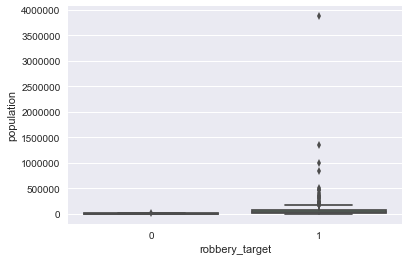

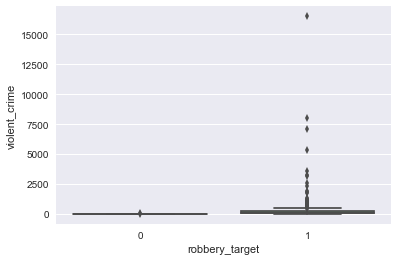

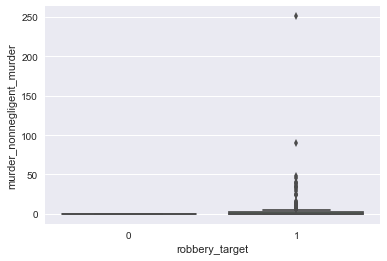

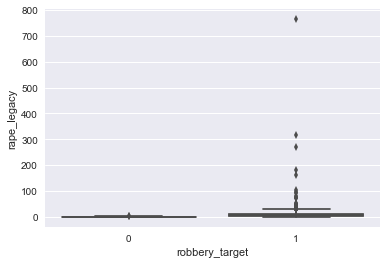

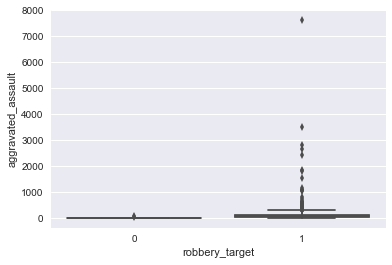

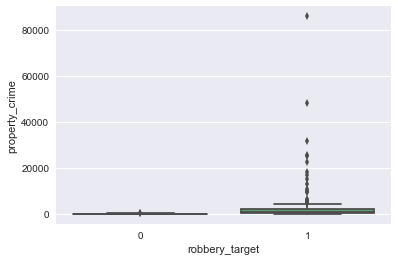

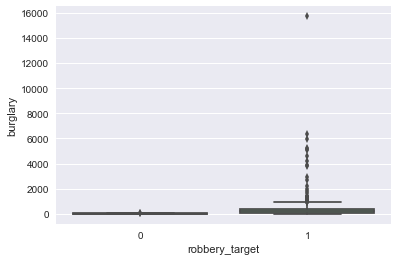

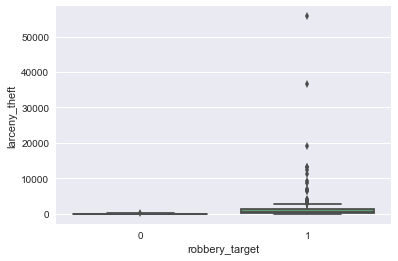

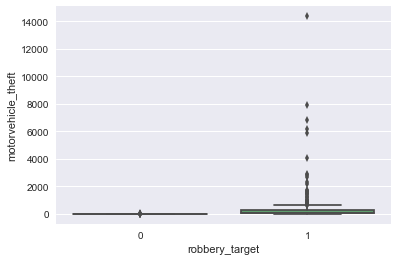

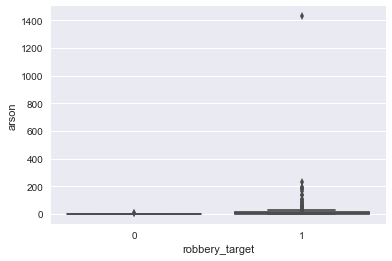

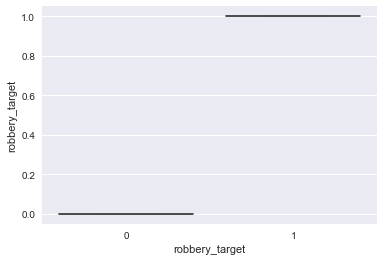

In [14]:
# Examine data; areas where no robbery occurred also have significantly lower
# crime rates in general 
for column in df.columns:
    sns.boxplot(x='robbery_target',y=column,data=df)
    plt.show()

## Feature Selection

In [17]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Assign features and target variable to 'X' and 'Y' respectively
X = df.drop('robbery_target',axis=1)
Y = df['robbery_target']

# Instantiate Logistic Regression model
lr = LogisticRegression()

attributes = [1,2,3,4,5,6,7,8,9,10]
scores = []

# Iterate through number of features and store their performance during cross validation
for i in range(11):
    if i > 0:
        selector = SelectKBest(mutual_info_classif,k=i)
        selector.fit(X,Y)
        idxs_selected = selector.get_support(indices=True)
        result = X[X.columns[[idxs_selected]]]
        lr_score = cross_val_score(lr,result,Y,cv=10)
        scores.append(np.mean(lr_score))

# Assign best performing score to 'best'
best = max(scores)

best_num = scores.index(best)+1

# Return number of features that yielded the best performance
print('The optimal number of features is',best_num,'')


The optimal number of features is 1 


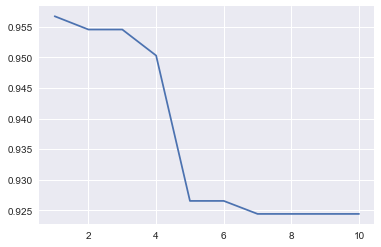

In [18]:
# It appears that a lot of the features in the data set are not 
# strongly related to the target variable. 
plt.plot(attributes,scores)

In [19]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif




# Use mutual information to select best features
selector = SelectKBest(mutual_info_classif,k=best_num)

# Fit selector to data
selector.fit(X,Y)

# Assign selected features 
idxs_selected = selector.get_support(indices=True)
result = X[X.columns[[idxs_selected]]]

In [20]:
# Preview selected features
result.head(5)

,violent_crime
0,198
1,19
2,158
3,29
4,163


# Logistic Regression

In [21]:
# Fit logistic regression model
lr = LogisticRegression()
fit = lr.fit(result,Y)
print(lr.score(result,Y))

0.95670995671


In [22]:
# Evaluate performnace during cross validation
lr_score = cross_val_score(lr,result,Y,cv=10)
print(np.mean(lr_score))

0.956740672217


In [23]:
# Evaluate coefficients
print(lr.coef_)
print(lr.intercept_)

[[ 0.17232352]]
[-0.74635958]


# Ridge Regression

In [24]:
# Identify optimal lambda value 
ridge_cv = LogisticRegressionCV(penalty='l2')
model_cv = ridge_cv.fit(result,Y)
ridge_lambda = float(model_cv.C_)

In [25]:
# Fit Ridge regression model to data with optimal lambda value 
ridger = LogisticRegression(penalty='l2',C=ridge_lambda)
fit = ridger.fit(result,Y)
print(ridger.score(result,Y))

0.9329004329


In [26]:
# Evaluate performance during cross validation
ridge_score = cross_val_score(ridger,result,Y,cv=10)
print(np.mean(ridge_score))

0.933054784664


In [27]:
# Evaluate coefficients
print(ridger.coef_)
print(ridger.intercept_)

[[ 0.11772636]]
[-0.03223094]


In [28]:
ridge_lambda

0.005994842503189409

# Lasso Regression

In [29]:
# Identify optimal lambda for lasso regression model 
lasso_cv = LogisticRegressionCV(penalty='l1',solver='liblinear')
model_cv = lasso_cv.fit(result,Y)
lasso_lambda = float(model_cv.C_)

In [30]:
# Fit lesson regression model to data with optimal lambda
lassor = LogisticRegression(penalty='l1',C=lasso_lambda)
fit = lassor.fit(result,Y)
print(lassor.score(result,Y))

0.9329004329


In [31]:
# Evaluate performance during cross validation
lassor_score = cross_val_score(lassor,result,Y,cv=10)
print(np.mean(lassor_score))

0.933054784664


In [32]:
# Evaluate coefficients 
print(lassor.coef_)
print(lassor.intercept_)

[[ 0.00664004]]
[ 0.]


## Conclusion



The best model appears to be the vanilla logistic regression model. 

A lot of the complexity (e.g., multicollinearity + large coefficients) that ridge and lasso are meant to deal with were addressed during the feature selection process. 

The optimal number of features were chosen by performing cross validation and seeing what number of features allow the model to perform the best. 

Optimal lambda values for Ridge and Lasso were chosen using cross validation. 